# "Segmentez des clients d'un site e-commerce"
_Cleaning Notebook_

## 0 Preliminaries

In [186]:
# !pip install flake8 pycodestyle_magic
# !pip install gtts
# !pip install category-encoders
# !pip install mlxtend==0.17.3 # makes Google Colab asking for reboot
# !pip install ppscore

In [187]:
# !pip freeze > requirements_cleaning_eda.txt

Checking for PEP8 compliance

In [188]:
# %load_ext pycodestyle_magic
# %pycodestyle_on
# %pycodestyle_off

### 0.0 Importing Packages and Modules

Checking whether the notebook is on Colab or PC

In [189]:
import sys
is_colab = 'google.colab' in sys.modules
is_colab, sys.executable

(True, '/usr/bin/python3')

Mounting my Drive if on colab

In [190]:
if is_colab==True:
    from google.colab import files, output, drive
    drive.mount('/gdrive')
    %cd /gdrive
    print("You're on Google Colab")
else:
    print("You're on a PC")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
You're on Google Colab


Installations and importations required in the virtual environment.

In [191]:
import os
if is_colab==True:
    if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET5/NOTEBOOKS':
        os.chdir('My Drive/--DATA SCIENCE/PROJET5/NOTEBOOKS')
else:
    if not (os.path.exists(os.getcwd()+'/requirements_cleaning_eda.txt') \
                     and os.path.exists(os.getcwd()+'/P5_functions.py')):
        print("ERROR: Make sure 'P5_functions.py' and 'requirements_cleaning_eda.txt' are in the current working directory")

!pip install -r requirements_cleaning_eda.txt
from P5_functions import *

Importation of modules and packages. 

In [192]:
import io

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'

import missingno as msno
import ppscore as pps

import dill

Setting pandas display options

In [193]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                    'display.max_colwidth': 100,
                    'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
  pd.set_option(k,v)

To play audio text-to-speech during execution.

In [194]:
from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

In [195]:
speak('Packages and modules successfully imported')

### 0.1 Importing the Aggregated Orders dataset

We load in a dataframe the dataset of aggregated orders obtained from "P5_Cleaning_1.ipynb".

In [196]:
# from datetime import strptime

if is_colab==True:
    # Importing database from my Drive
    print("Try to import data files in the notebook from myDrive...")
else:
    # Importing database from PC
    print("Try to import data files in the notebook from PC ('DATA')...")

df_orders = pd.read_csv('agg_orders.csv', sep=',', index_col='order_id',
                        encoding ='utf-8').drop(columns=['Unnamed: 0'])
df_order_items = pd.read_csv('agg_order_items.csv', sep=',', index_col='order_id',
                        encoding ='utf-8').drop(columns=['Unnamed: 0'])

print("-----> Importation of .csv in the notebook: OK")

Try to import data files in the notebook from myDrive...
-----> Importation of .csv in the notebook: OK


In [197]:
df_orders.dtypes

customer_unique_id           object
cust_lat                    float64
cust_long                   float64
cust_region                  object
order_status                 object
order_purchase_timestamp     object
order_item_nb               float64
mean_prod_descr_length      float64
product_volume_cm3          float64
product_weight_g            float64
main_prod_categ              object
shipping_time                object
shipping_delay               object
max_limit_ship_date          object
delivered                     int64
seller_id                    object
freight_value               float64
price                       float64
seller_lat                  float64
seller_long                 float64
seller_region                object
review_score                float64
review_comment_length       float64
cum_paytype                  object
paytype_boleto              float64
paytype_credit_card         float64
paytype_debit_card          float64
paytype_not_defined         

In [198]:
speak('Dataset successfully imported')

## 1 Building the Customer dataset

Let's now aggregate all the orders to get a dataset of the customers.

### 1.1 Aggregation of orders to get customers dataframe

In [199]:
df_orders.columns

Index(['customer_unique_id', 'cust_lat', 'cust_long', 'cust_region', 'order_status',
       'order_purchase_timestamp', 'order_item_nb', 'mean_prod_descr_length', 'product_volume_cm3',
       'product_weight_g', 'main_prod_categ', 'shipping_time', 'shipping_delay',
       'max_limit_ship_date', 'delivered', 'seller_id', 'freight_value', 'price', 'seller_lat',
       'seller_long', 'seller_region', 'review_score', 'review_comment_length', 'cum_paytype',
       'paytype_boleto', 'paytype_credit_card', 'paytype_debit_card', 'paytype_not_defined',
       'paytype_voucher', 'payment_installments', 'payment_value', 'cat_books', 'cat_electronics',
       'cat_diy', 'cat_leisure', 'cat_miscellaneous', 'cat_food', 'cat_hygiene', 'cat_unknown',
       'cat_fashion', 'cat_furniture', 'cat_office', 'cat_multimedia', 'cat_home'],
      dtype='object')

We aggregate the df_orders columns by customer : (see 'create_agg_cust_df' in P5_functions.py) :

- if multiple orders per customer, 'customer_unique_id', 'cust_lat', 'cust_long', 'cust_region', 'order_status', 'main_prod_categ', 'cum_paytype' are these of the last 'order_purchase_timestamp'
- 'tot_nb_deliv_ord' is the sum of 'delivered' column
- 'tot_nb_items', 'tot_price', 'tot_freight_val', 'tot_pay_value' and 'tot_comment_length' are the sum of the corresponding columns
- 'tot_nb_ord': is the number of delivered order (agg by size)
- 'time_since_last_purch': is t_max minus maximum 'order_purchase_timestamp'
- 'time_since_first_purch': is t_max minus minimum 'order_purchase_timestamp'
- 'mean_ship_time', 'mean_ship_delay', 'mean_nb_items_per_ord','mean_prod_descr_length', 'mean_prod_vol_cm3', 'mean_prod_wei_g',   'mean_price_per_order', 'mean_freight_val_per_order',  'mean_pay_value_per_order', 'mean_pay_install', 'mean_rev_score', 'mean_comment_length' are the mean of the corresponding columns.
    
The Dummy columns ("cat_XXX" and "paytype_XXX" columns) are also aggregated using sums.

Aggregation of the customers can be done on different time slots. Default is aggregation on the whole dataset.

In [350]:
# Aggregation in a chosen time slot
# all customers (for max period of time): (96095, 22)

print("Min time (purchase) in df_orders (default if t_min is None)",
      df_orders.order_purchase_timestamp.min())
print("Max time (purchase) in df_orders (default if t_max is None",
      df_orders.order_purchase_timestamp.max())
# t_min = pd.Timestamp('2017-10-17 17:30:18')
# t_max = pd.Timestamp('2018-01-01 17:30:18')

df_cust = create_agg_cust_df(df_orders, t_min=None, t_max=None)

Min time (purchase) in df_orders (default if t_min is None) 2016-09-04 21:15:19
Max time (purchase) in df_orders (default if t_max is None 2018-10-17 17:30:18


In [351]:
df_cust.columns

Index(['cust_lat', 'cust_region', 'cust_long', 'mean_nb_items_per_ord', 'tot_nb_items',
       'mean_freight_val_per_order', 'tot_freight_val', 'mean_price_per_order', 'tot_price',
       'tot_nb_ord', 'tot_nb_deliv_ord', 'order_status', 'mean_ship_delay',
       'time_since_last_purch', 'time_since_first_purch', 'mean_ship_time', 'mean_rev_score',
       'mean_prod_descr_length', 'tot_comment_length', 'main_prod_categ', 'mean_prod_wei_g',
       'mean_prod_vol_cm3', 'mean_comment_length', 'mean_pay_value_per_order',
       'paytype_boleto_tot_nb', 'cum_paytype', 'tot_pay_value', 'mean_pay_install',
       'paytype_not_defined_tot_nb', 'paytype_credit_card_tot_nb', 'paytype_debit_card_tot_nb',
       'paytype_voucher_tot_nb', 'cat_multimedia_tot_nb', 'cat_office_tot_nb',
       'cat_leisure_tot_nb', 'cat_books_tot_nb', 'cat_diy_tot_nb', 'cat_home_tot_nb',
       'cat_food_tot_nb', 'cat_miscellaneous_tot_nb', 'cat_fashion_tot_nb',
       'cat_electronics_tot_nb', 'cat_furniture_tot_nb',

### 1.2 Feature engineering

In [202]:
df_cust.shape

(96096, 40)

In [203]:
df_cust.head(3)

,cust_region,mean_nb_items_per_ord,tot_nb_items,mean_freight_val_per_order,tot_freight_val,mean_price_per_order,tot_price,tot_nb_ord,tot_nb_deliv_ord,mean_ship_delay,time_since_last_purch,mean_ship_time,time_since_first_purch,tot_comment_length,mean_rev_score,mean_prod_descr_length,mean_prod_wei_g,mean_prod_vol_cm3,mean_comment_length,mean_pay_value_per_order,paytype_not_defined_tot_nb,paytype_boleto_tot_nb,paytype_credit_card_tot_nb,paytype_debit_card_tot_nb,paytype_voucher_tot_nb,tot_pay_value,mean_pay_install,cat_multimedia_tot_nb,cat_office_tot_nb,cat_leisure_tot_nb,cat_food_tot_nb,cat_miscellaneous_tot_nb,cat_books_tot_nb,cat_fashion_tot_nb,cat_electronics_tot_nb,cat_furniture_tot_nb,cat_hygiene_tot_nb,cat_diy_tot_nb,cat_home_tot_nb,cat_unknown_tot_nb
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,SE,1.00,1.00,12.00,12.00,129.90,129.90,1,1,6 days 09:52:10,160 days 06:33:51,6 days 09:52:10,160 days 06:33:51,111.00,5.00,236.00,1500.00,7616.00,111.00,141.90,0.00,0.00,1.00,0.00,0.00,141.90,8.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,129.90,0.00,0.00,129.90,0.00
0000b849f77a49e4a4ce2b2a4ca5be3f,SE,1.00,1.00,8.29,8.29,18.90,18.90,1,1,3 days 06:51:15,163 days 06:18:51,3 days 06:51:15,163 days 06:18:51,0.00,4.00,635.00,375.00,5148.00,0.00,27.19,0.00,0.00,1.00,0.00,0.00,27.19,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18.90,0.00,0.00,0.00
0000f46a3911fa3c0805444483337064,S,1.00,1.00,17.22,17.22,69.00,69.00,1,1,25 days 17:33:44,585 days 20:25:15,25 days 17:33:44,585 days 20:25:15,0.00,3.00,177.00,1500.00,43750.00,0.00,86.22,0.00,0.00,1.00,0.00,0.00,86.22,8.00,0.00,69.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


We add to the df_cust dataframe new features using the "create_features_cust_df" function (see P5_functions.py) :

Conversion of timedeltas
    time_cols = df_cust_mod.select_dtypes(include=['timedelta64[ns]']).columns
    for c in time_cols:
        df_cust_mod[c] = df_cust_mod[c].apply(lambda x: x.days)

Adding the 'single purchase' column:

    ser = (df_cust_mod['tot_nb_ord']==1).map({True: 1, False: 0})
    df_cust_mod.insert(loc=11, column='single_purch', value=ser)

Adding the total number of not received orders:

    ser = (df_cust_mod['tot_nb_ord']-df_cust_mod['tot_nb_deliv_ord'])
    df_cust_mod.insert(loc=12, column='nb_not_rec_orders', value=ser)

Adding the average freight on payment value ratio:

    ser = df_cust_mod['tot_freight_val']/df_cust_mod['tot_pay_value']
    df_cust_mod.insert(loc=8, column='avg_freight_payval_ratio', value=ser.fillna(0))



Then we use the function on df_cust:

In [363]:
df_cust = create_features_cust_df(df_cust)

## 2 Data exploration

In [364]:
df_cust.shape

(96096, 48)

#### Describe

In [365]:
df_cust.describe(include='all')

,cust_lat,cust_region,cust_long,mean_nb_items_per_ord,tot_nb_items,mean_freight_val_per_order,tot_freight_val,mean_price_per_order,avg_freight_payval_ratio,tot_price,tot_nb_ord,tot_nb_deliv_ord,single_purch,nb_not_rec_orders,order_status,mean_ship_delay,time_since_last_purch,time_since_first_purch,mean_ship_time,mean_rev_score,mean_prod_descr_length,tot_comment_length,main_prod_categ,mean_prod_wei_g,mean_prod_vol_cm3,mean_comment_length,mean_pay_value_per_order,paytype_boleto_tot_nb,cum_paytype,tot_pay_value,mean_pay_install,paytype_not_defined_tot_nb,paytype_credit_card_tot_nb,paytype_debit_card_tot_nb,paytype_voucher_tot_nb,cat_multimedia_tot_nb,cat_office_tot_nb,cat_leisure_tot_nb,cat_books_tot_nb,cat_diy_tot_nb,cat_home_tot_nb,cat_food_tot_nb,cat_miscellaneous_tot_nb,cat_fashion_tot_nb,cat_electronics_tot_nb,cat_furniture_tot_nb,cat_hygiene_tot_nb,cat_unknown_tot_nb
count,96096.00,96096,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096,96096.00,96096.00,96096.00,96096.00,96096.00,96096,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00,96096.00
unique,nan,5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,8,nan,nan,nan,nan,nan,nan,nan,74,nan,nan,nan,nan,nan,8,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,nan,SE,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,delivered,nan,nan,nan,nan,nan,nan,nan,bed_bath_table,nan,nan,nan,nan,nan,C,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,nan,66118,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,93270,nan,nan,nan,nan,nan,nan,nan,8825,nan,nan,nan,nan,nan,71776,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,-21.12,NaN,-46.11,1.13,1.17,22.65,23.43,137.16,0.20,141.44,1.03,1.00,0.97,0.03,NaN,11.75,287.74,290.46,11.75,4.06,778.56,30.13,NaN,2091.85,15134.42,29.26,161.40,0.21,NaN,166.59,2.97,0.00,0.80,0.02,0.16,0.60,5.67,31.94,0.73,8.72,31.87,0.72,14.58,2.10,36.21,22.77,21.55,1.87
std,5.72,NaN,4.10,0.53,0.63,21.56,22.88,210.74,0.13,217.22,0.21,0.27,0.17,0.17,NaN,9.63,153.41,153.90,9.63,1.36,653.24,50.85,NaN,3731.96,23258.20,49.23,222.31,0.42,NaN,231.43,2.72,0.01,0.49,0.13,2.94,14.91,41.15,116.80,12.23,67.15,96.47,13.31,99.80,21.72,156.97,72.73,88.82,30.05
min,-33.68,NaN,-72.46,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,NaN,0.00,0.00,0.00,0.00,0.33,0.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,-23.58,NaN,-48.05,1.00,1.00,13.75,13.92,45.83,0.11,45.99,1.00,1.00,1.00,0.00,NaN,6.00,163.00,166.00,6.00,4.00,341.00,0.00,NaN,300.00,2816.00,0.00,62.46,0.00,NaN,63.12,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,-22.90,NaN,-46.61,1.00,1.00,17.16,17.53,85.99,0.18,89.00,1.00,1.00,1.00,0.00,NaN,10.00,268.00,272.00,10.00,5.00,599.00,0.00,NaN,700.00,6400.00,0.00,105.82,0.00,NaN,108.00,2.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,-20.05,NaN,-43.44,1.00,1.00,23.99,25.42,149.90,0.27,154.00,1.00,1.00,1.00,0.00,NaN,15.00,397.00,400.00,15.00,5.00,985.00,44.00,NaN,1813.00,18040.00,43.00,177.21,0.00,NaN,183.53,4.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,16.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [207]:
df_cust.dtypes.value_counts()

float64    34
int64       8
object      1
dtype: int64

### 2.1 Quantitative data

In [208]:
Q_cols = df_cust.select_dtypes(include=[np.number]).columns
Q_cols

Index(['mean_nb_items_per_ord', 'tot_nb_items', 'mean_freight_val_per_order', 'tot_freight_val',
       'mean_price_per_order', 'tot_price', 'tot_nb_ord', 'avg_freight_payval_ratio',
       'tot_nb_deliv_ord', 'mean_ship_delay', 'time_since_last_purch', 'single_purch',
       'nb_not_rec_orders', 'mean_ship_time', 'time_since_first_purch', 'tot_comment_length',
       'mean_rev_score', 'mean_prod_descr_length', 'mean_prod_wei_g', 'mean_prod_vol_cm3',
       'mean_comment_length', 'mean_pay_value_per_order', 'paytype_not_defined_tot_nb',
       'paytype_boleto_tot_nb', 'paytype_credit_card_tot_nb', 'paytype_debit_card_tot_nb',
       'paytype_voucher_tot_nb', 'tot_pay_value', 'mean_pay_install', 'cat_multimedia_tot_nb',
       'cat_office_tot_nb', 'cat_leisure_tot_nb', 'cat_food_tot_nb', 'cat_miscellaneous_tot_nb',
       'cat_books_tot_nb', 'cat_fashion_tot_nb', 'cat_electronics_tot_nb', 'cat_furniture_tot_nb',
       'cat_hygiene_tot_nb', 'cat_diy_tot_nb', 'cat_home_tot_nb', 'cat_unkn

In [209]:
len(Q_cols)

42

#### Boxplots

independant features

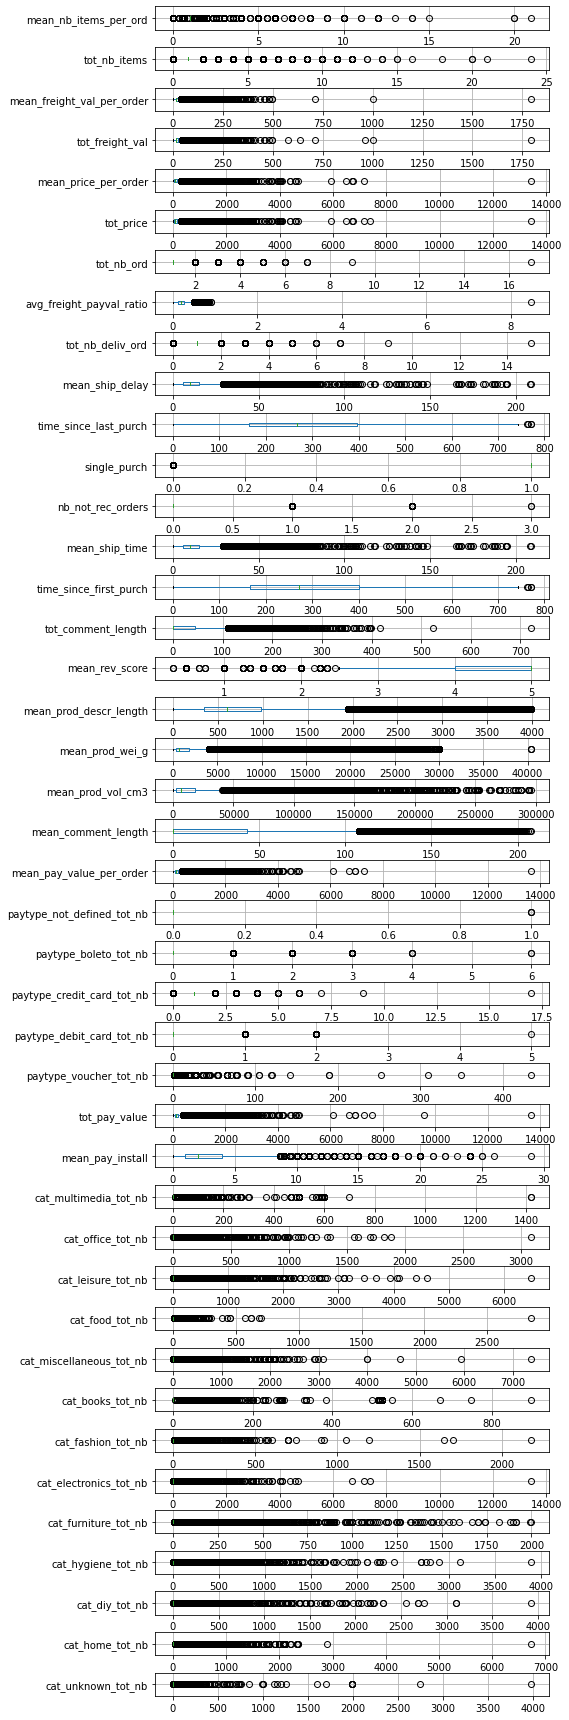

In [210]:
fig, axs = plt.subplots(len(df_cust[Q_cols].columns),1,
                        figsize=(8, 24), sharey=False)
for c, ax in zip(df_cust[Q_cols].columns, axs):
    df_cust.boxplot(c, vert=False, ax=ax)
fig.tight_layout(h_pad=0.051)
plt.show()

#### Histograms

Plotting histograms of the main quantitative continuous columns.

* Histograms of independant features

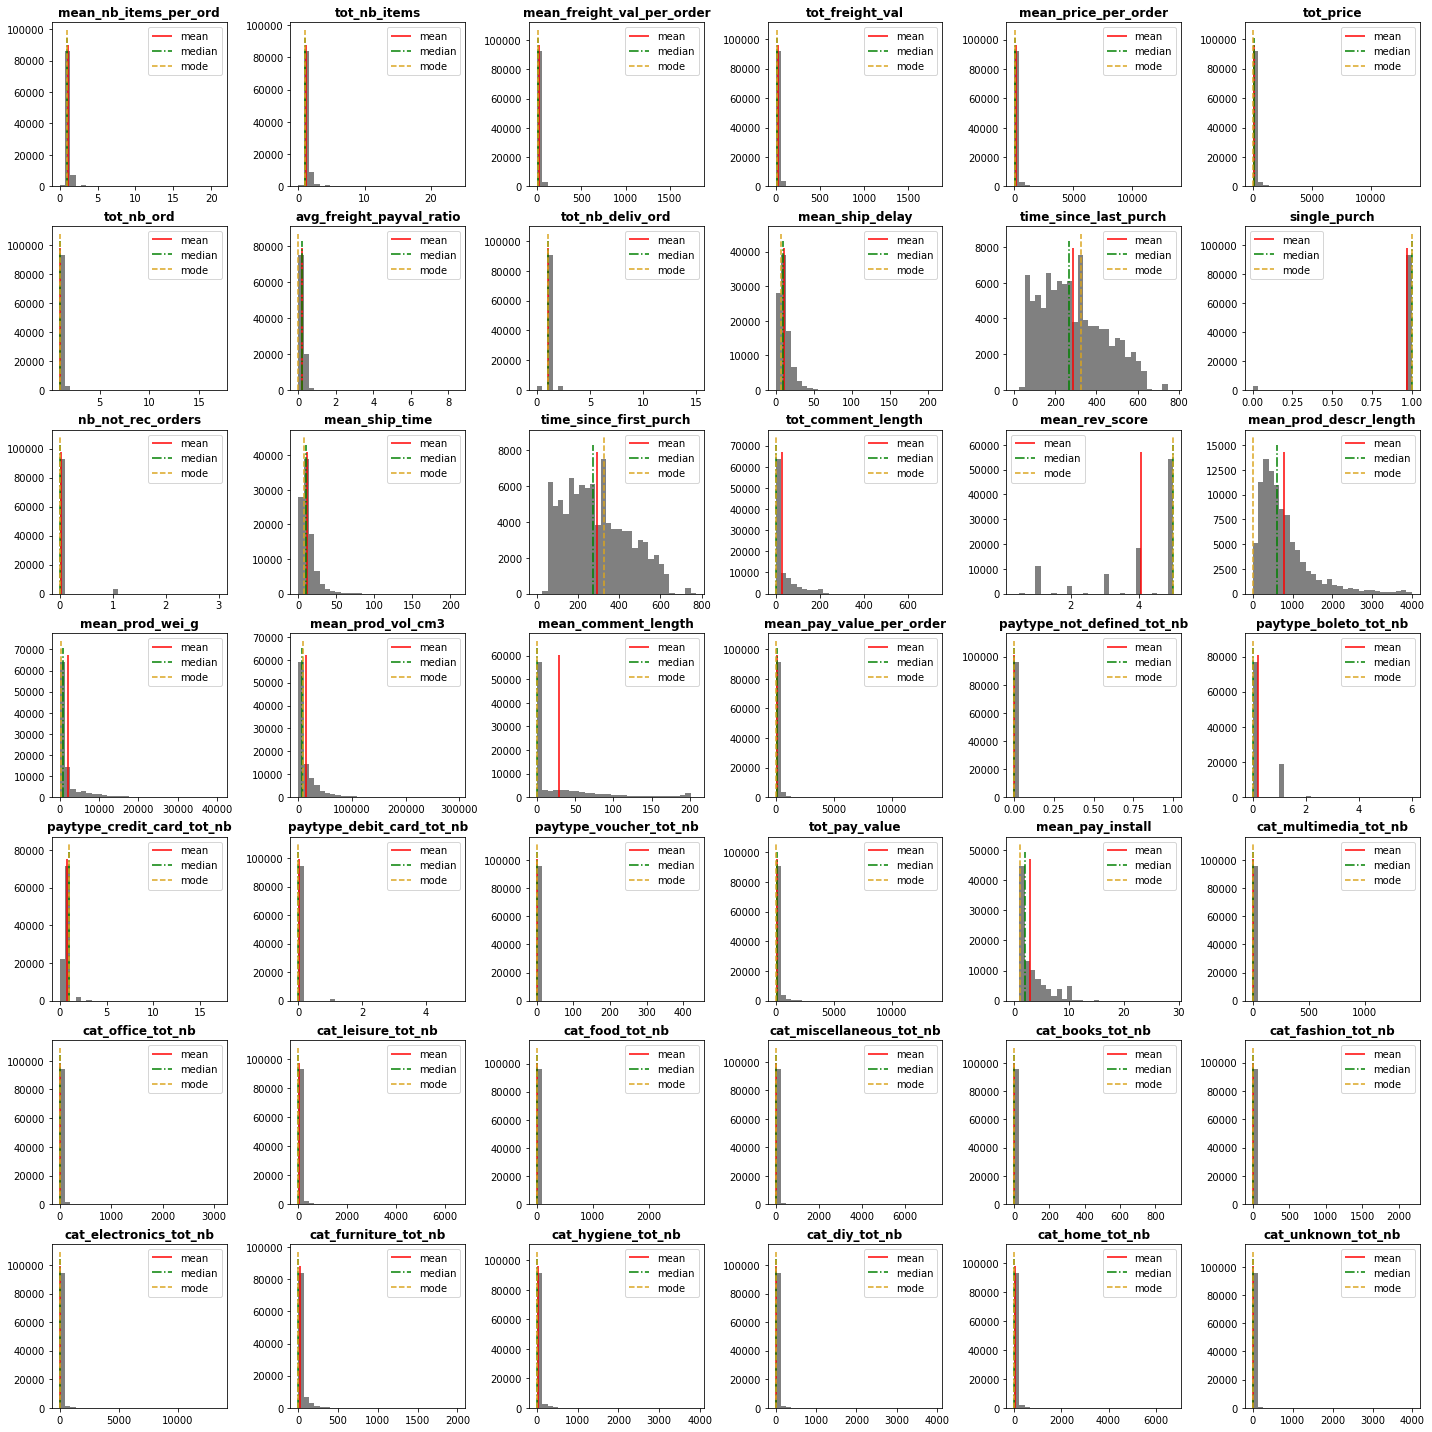

In [211]:
# All the data (with outliers)
plot_histograms(df=df_cust, cols=Q_cols,
                figsize=(20,20), bins=30, layout=(7,6), skip_outliers=False,
                thresh=3, save_enabled=False)

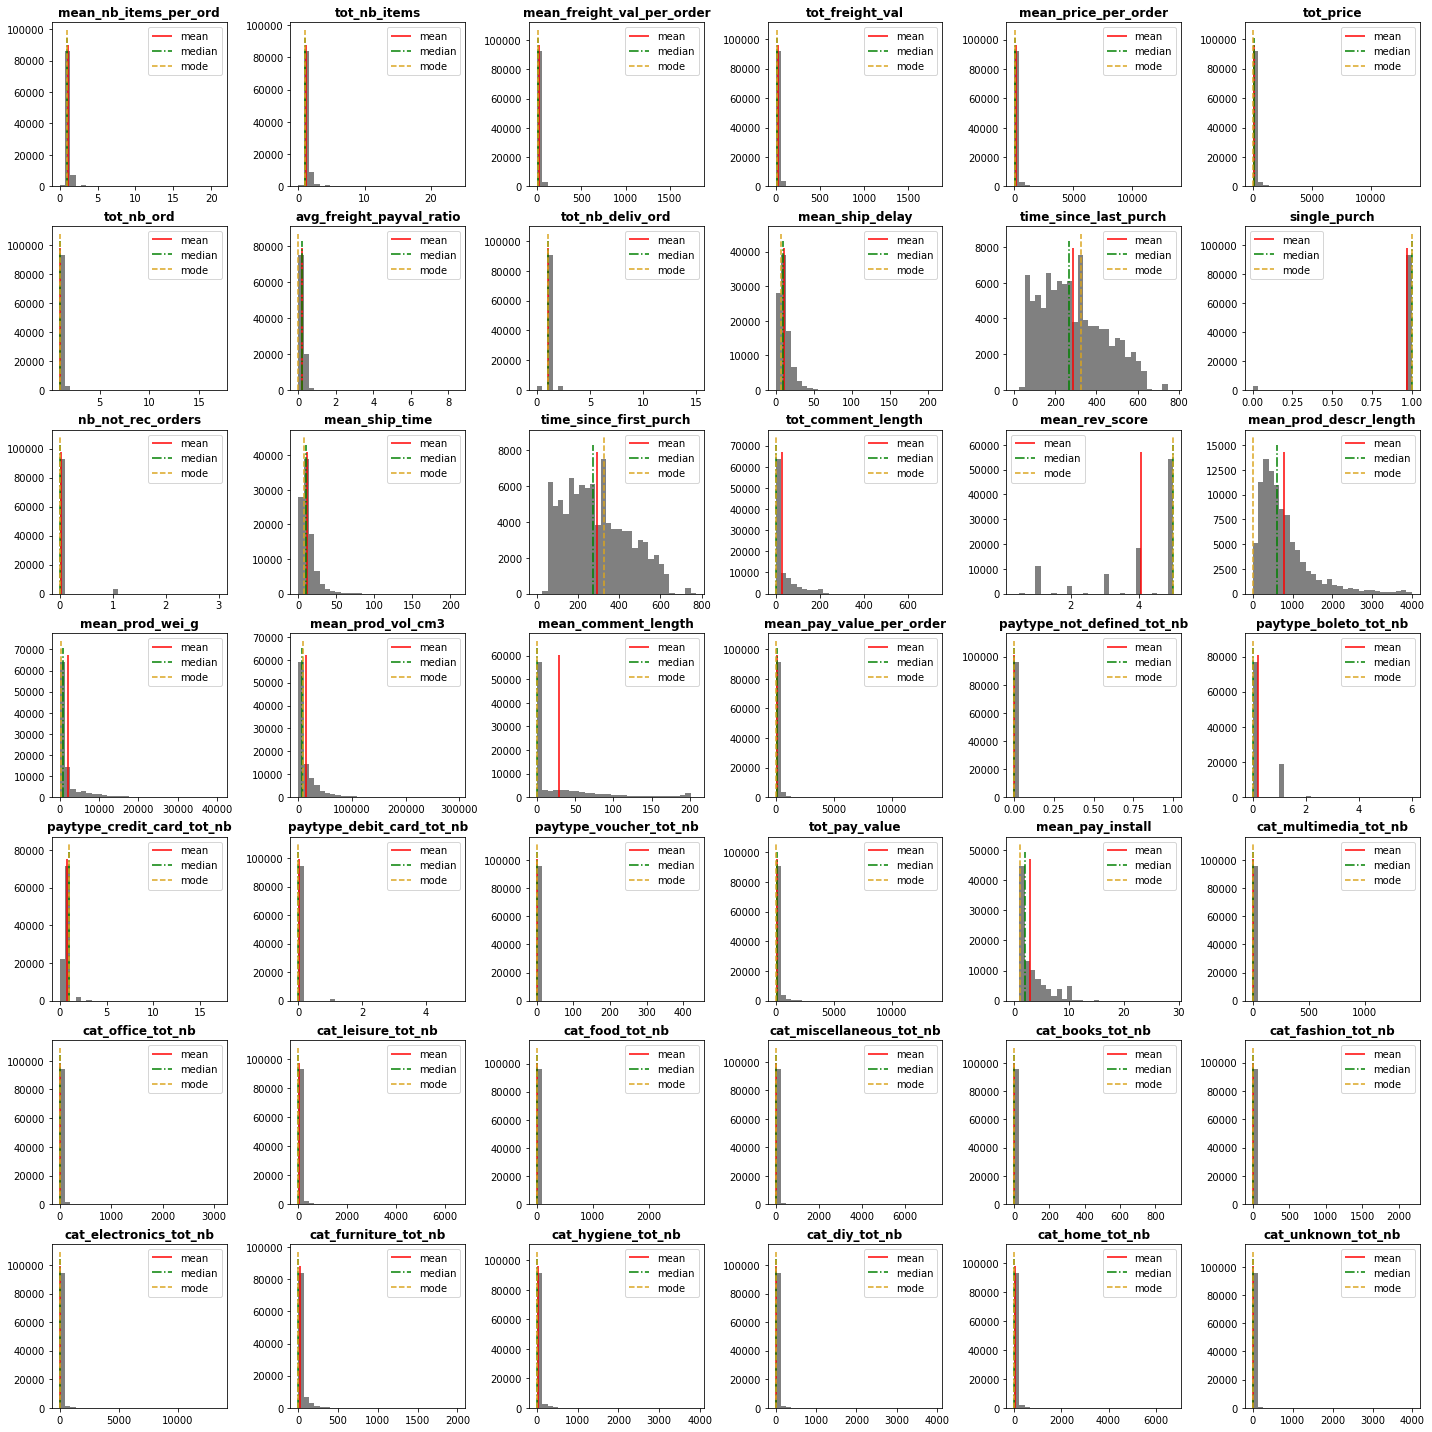

In [212]:
# Selection of data (with outliers)
plot_histograms(df=df_cust, cols=Q_cols,
                figsize=(20,20), bins=30, layout=(7,6), skip_outliers=False,
                thresh=3, save_enabled=False)

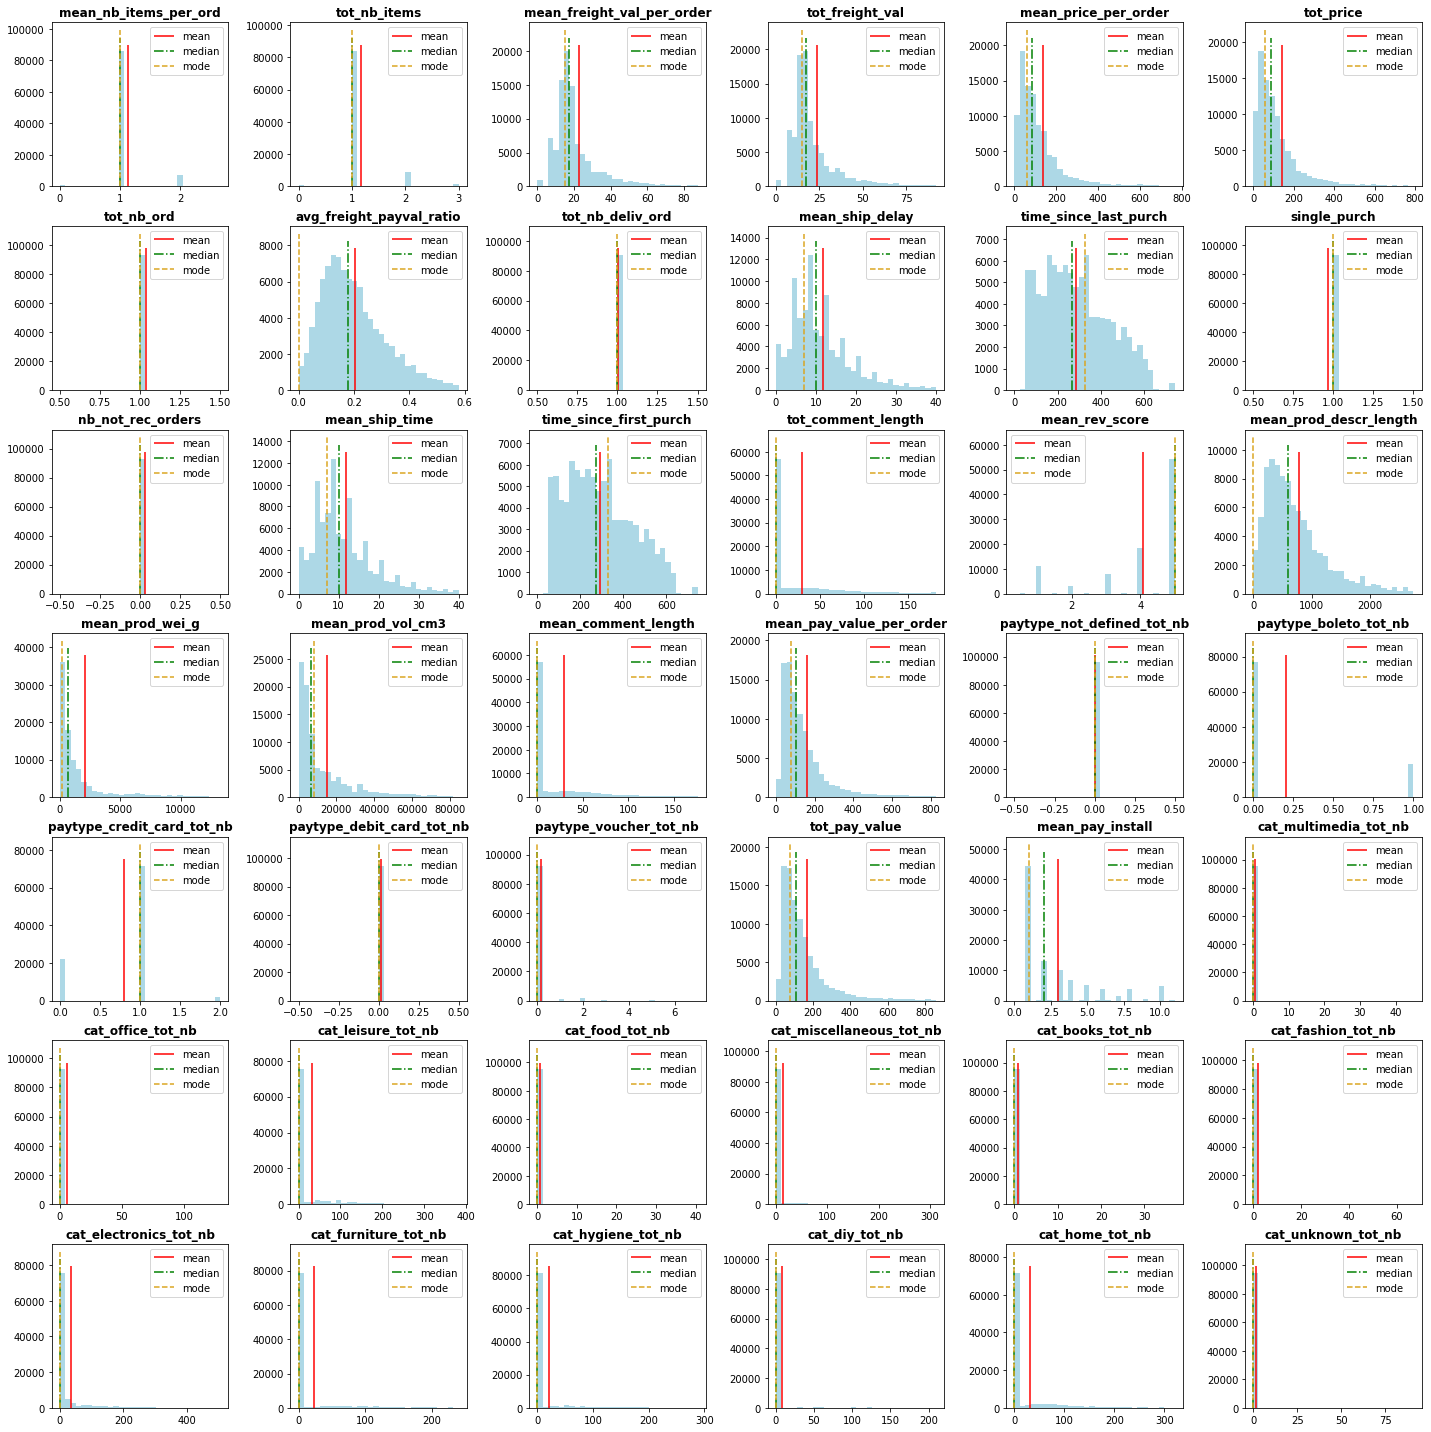

In [213]:
# Excluding outliers to get a better scale
plot_histograms(df=df_cust, cols=Q_cols, color = 'lightblue',
                figsize=(20,20), bins=30, layout=(7,6), skip_outliers=True,
                thresh=3, save_enabled=False)

#### Correlations

Linear correlation (Pearson)

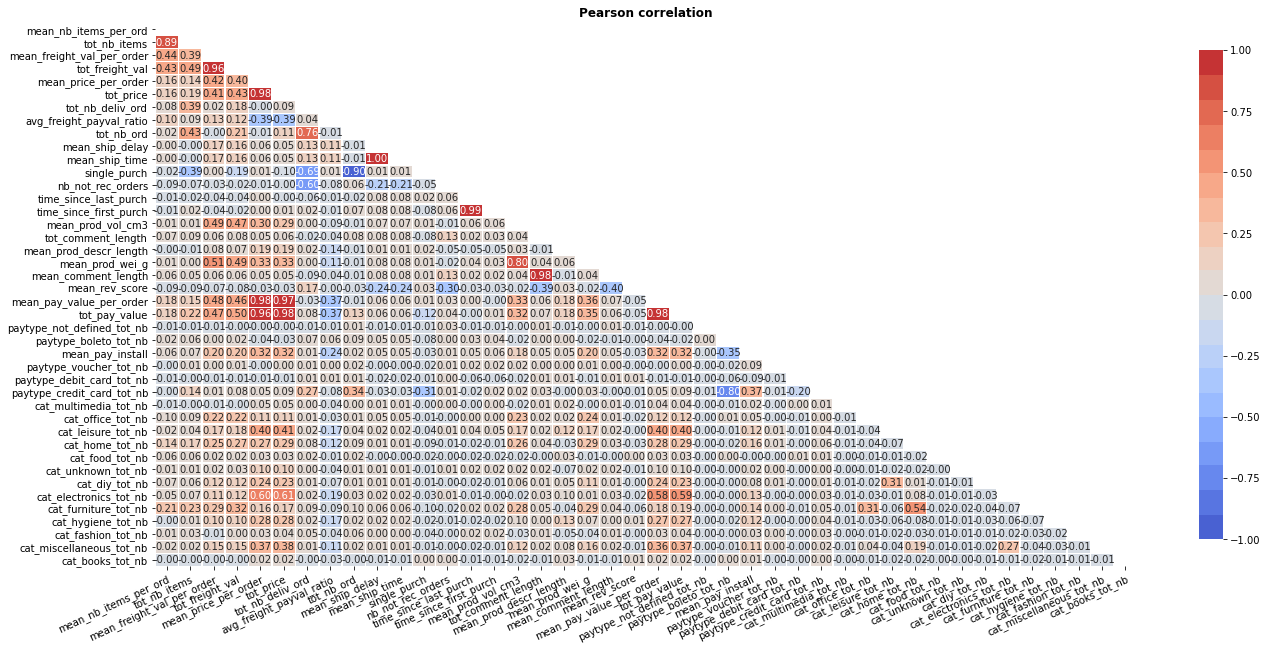

In [ ]:
pears_corr = df_cust[Q_cols].corr()
plot_heatmap(pears_corr, shape='tri',
             title="Pearson correlation", figsize=(22,10))
plt.show()

#### PCA

In [580]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Transformation and encoding
ct = CustTransformer(strat_low_card='ohe', # Ordinal encoding for 'region'
                     strat_quant='stand') # Standardization for quantitative data
df_cust_trans = ct.fit_transform(df_cust)

In [599]:
pca_cols = df_cust_trans.columns[
    ~df_cust_trans.columns.str.contains('cat_|paytype_|high_card|low_card',
                                       regex=True)]
pca_cols

Index(['binary__single_purch', 'cust_lat', 'cust_long', 'mean_nb_items_per_ord', 'tot_nb_items',
       'mean_freight_val_per_order', 'tot_freight_val', 'mean_price_per_order',
       'avg_freight_payval_ratio', 'tot_price', 'tot_nb_ord', 'tot_nb_deliv_ord',
       'nb_not_rec_orders', 'mean_ship_delay', 'time_since_last_purch', 'time_since_first_purch',
       'mean_ship_time', 'mean_rev_score', 'mean_prod_descr_length', 'tot_comment_length',
       'mean_prod_wei_g', 'mean_prod_vol_cm3', 'mean_comment_length', 'mean_pay_value_per_order',
       'tot_pay_value', 'mean_pay_install'],
      dtype='object')

In [619]:
df_pca = df_cust_trans.loc[:, pca_cols]

n_comp = 10
pca = PCA(n_components=n_comp).fit(df_pca)

pca_df = pd.DataFrame(pca.components_,
                      index=['PC'+str(i+1) for i in range(n_comp)],
                      columns=pca_cols).T

df_pca_proj = pd.DataFrame(pca.transform(df_pca),
                           columns=['PC'+str(i) for i in range(n_comp)])
df_pca_proj.head(3)

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,-0.23,-0.92,-0.66,1.78,-0.37,-1.10,-1.06,0.30,-1.03,-1.83
1,-2.06,-0.63,1.16,0.54,-0.83,0.12,-0.00,0.02,0.13,0.03
2,-0.16,0.70,-1.26,-2.14,2.22,0.72,-0.73,-1.47,1.04,-1.14


Plotting principal components

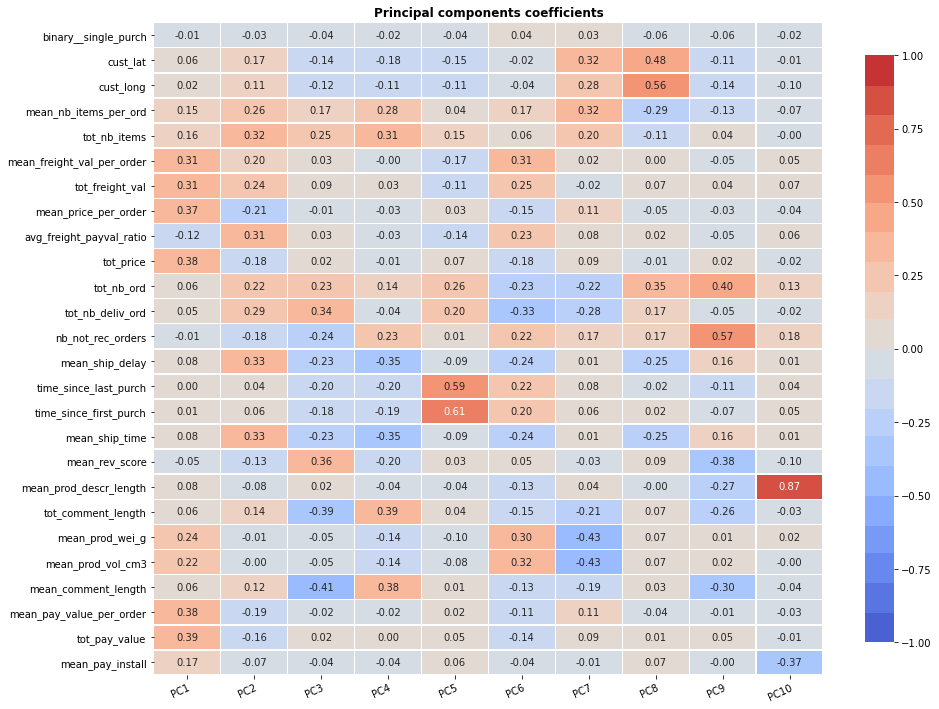

In [620]:
plot_heatmap(pca_df,'Principal components coefficients',
             vmin=-1, vmax=1, center=0,
             palette=sns.color_palette("coolwarm", 20),
             figsize=(15,12),shape='rect')
plt.show()

Plotting explained variance ratio in scree plot

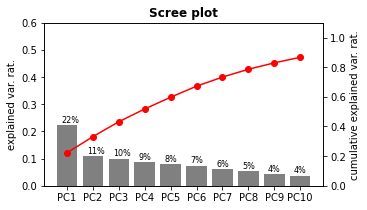

In [622]:
exp_var_rat = pca.explained_variance_ratio_
scree_plot(col_names= pca_df.columns, exp_var_rat=exp_var_rat,
           ylim=(0,0.6), figsize=(5,3))
plt.show()

First 20 principal components explain 80% of the variance of the data.

The PCA does not gather enough variance in the first components, it will be hard to use.

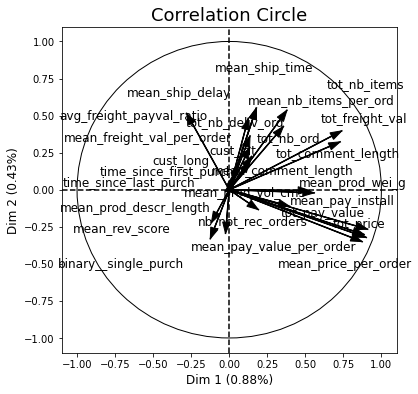

In [615]:
from mlxtend.plotting import plot_pca_correlation_graph # !pip install mlxtend==0.17.3

figure, correlation_matrix = \
     plot_pca_correlation_graph(X = df_cust_trans[pca_cols].values,
                                variables_names = pca_cols,
                                dimensions=(1, 2), figure_axis_size=6,
                                X_pca = df_pca_proj.values[:,0:2],
                                explained_variance = exp_var_rat[0:2])
plt.show()

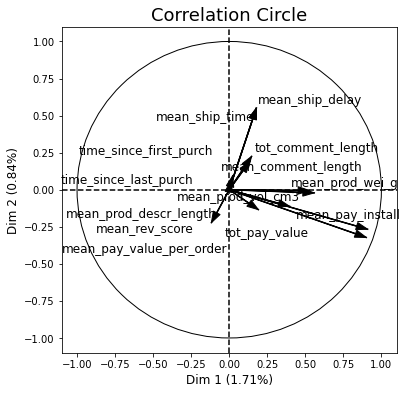

In [610]:
from mlxtend.plotting import plot_pca_correlation_graph # !pip install mlxtend==0.17.3

figure, correlation_matrix = \
     plot_pca_correlation_graph(X = df_cust_trans[pca_cols[13:]].values,
                                variables_names = pca_cols[13:],
                                dimensions=(1, 2), figure_axis_size=6,
                                X_pca = df_pca_proj.values[:,0:2],
                                explained_variance = exp_var_rat[0:2])
plt.show()

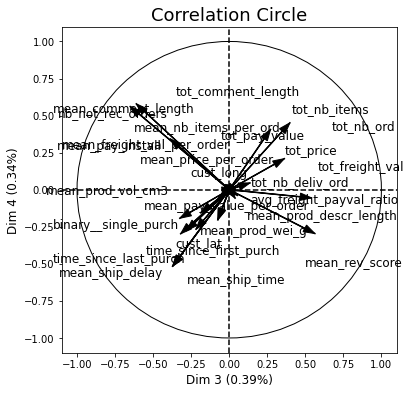

In [617]:
figure, correlation_matrix = \
     plot_pca_correlation_graph(X = df_cust_trans[pca_cols].values, variables_names = pca_cols,
                                dimensions=(3, 4), figure_axis_size=6,
                                X_pca = df_pca_proj.values[:,0:4],
                                explained_variance = exp_var_rat[0:4])
plt.show()

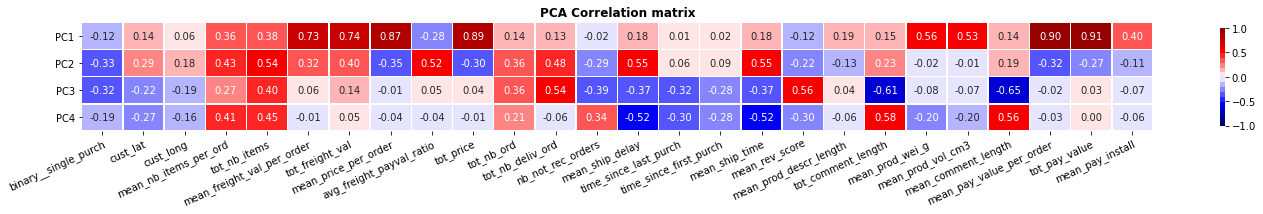

In [618]:
plot_heatmap(correlation_matrix.T,'PCA Correlation matrix',
             vmin=-1, vmax=1, center=0,
             palette=sns.color_palette("seismic", 20),
             figsize=(24,2),shape='rect')
plt.gca().set_yticklabels(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
plt.show()

### 2.2 Categorical data

In [325]:
C_cols = df_cust.select_dtypes(include=['object']).columns
C_cols

Index(['cust_region'], dtype='object')

#### Bar plots

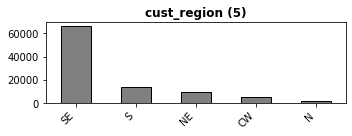

In [373]:
plot_barplots(df=df_cust, cols=['cust_region'], figsize=(5,2), layout=(1,1))

### 2.3 Custom vizualisations

In [343]:
df_cust.columns

Index(['cust_region', 'mean_nb_items_per_ord', 'tot_nb_items', 'mean_freight_val_per_order',
       'tot_freight_val', 'mean_price_per_order', 'tot_price', 'tot_nb_ord',
       'avg_freight_payval_ratio', 'tot_nb_deliv_ord', 'mean_ship_delay', 'time_since_last_purch',
       'single_purch', 'nb_not_rec_orders', 'mean_ship_time', 'time_since_first_purch',
       'tot_comment_length', 'mean_rev_score', 'mean_prod_descr_length', 'mean_prod_wei_g',
       'mean_prod_vol_cm3', 'mean_comment_length', 'mean_pay_value_per_order',
       'paytype_not_defined_tot_nb', 'paytype_boleto_tot_nb', 'paytype_credit_card_tot_nb',
       'paytype_debit_card_tot_nb', 'paytype_voucher_tot_nb', 'tot_pay_value', 'mean_pay_install',
       'cat_multimedia_tot_nb', 'cat_office_tot_nb', 'cat_leisure_tot_nb', 'cat_food_tot_nb',
       'cat_miscellaneous_tot_nb', 'cat_books_tot_nb', 'cat_fashion_tot_nb',
       'cat_electronics_tot_nb', 'cat_furniture_tot_nb', 'cat_hygiene_tot_nb', 'cat_diy_tot_nb',
       'cat_h

#### Geolocalisation effects
Is the region correlated to the value of the customers ?

In [476]:
100*df_cust['cust_region'].value_counts()/df_cust.shape[0]

SE   68.80
S    14.24
NE    9.47
CW    5.62
N     1.87
Name: cust_region, dtype: float64

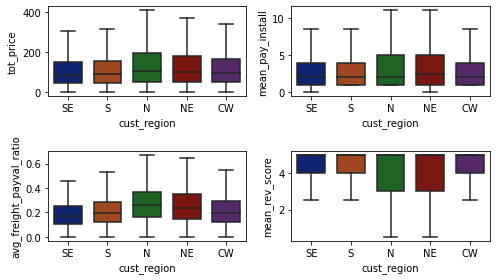

In [347]:
fig = plt.figure(figsize=(7,4))
layout=(2,2)
with sns.color_palette('dark'):
    for i, col in enumerate(['tot_price', 'mean_ship_time',
                             'avg_freight_payval_ratio', 'mean_rev_score'],1):
        ax = fig.add_subplot(*layout,i)
        sns.boxplot(data=df_cust,
                    x='cust_region', y=col, width=0.7, showfliers=False, ax=ax)
plt.tight_layout()
plt.show()

Let's see the geographical location of the customers

In [ ]:
# Getting the latitude and longitude width of the whole available locations
span_long, span_lat = \
    list((df_orders[['cust_long', 'cust_lat']].max()-\
          df_orders[['cust_long', 'cust_lat']].min()).values*10)
span_long, span_lat = int(round(span_long)), int(round(span_lat))
span_long, span_lat

(863, 787)

In [ ]:
# COmputing a density of customers using bins
df_loc_cust = df_orders[['cust_long', 'cust_lat']].copy('deep')
df_loc_cust['bin_lat'] = pd.cut(df_orders['cust_lat'],
                                bins=span_lat, labels=range(span_lat))
df_loc_cust['bin_long'] = pd.cut(df_orders['cust_long'],
                                 bins=span_long, labels=range(span_long))
dict_size_bins = dict(df_loc_cust.groupby(['bin_lat', 'bin_long']).size())
df_loc_cust['lat_long'] = list(zip(df_loc_cust.bin_lat, df_loc_cust.bin_long))
df_loc_cust['nb_cust_bin'] = df_loc_cust['lat_long'].map(dict_size_bins)

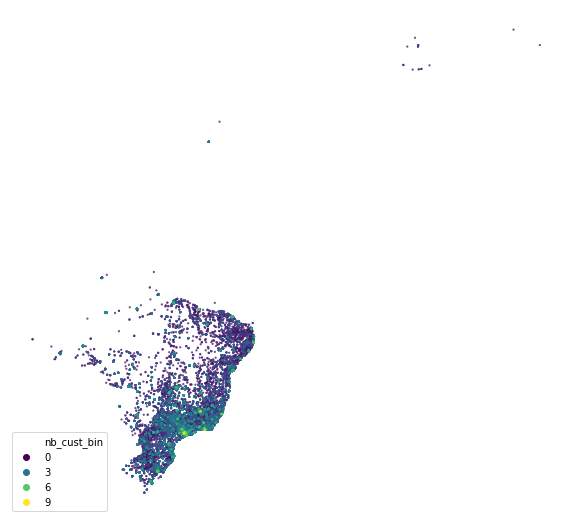

In [ ]:
fig, ax = plt.subplots(1)
sns.scatterplot(df_loc_cust['cust_long'], df_loc_cust['cust_lat'],
                s=5, hue = np.log(df_loc_cust['nb_cust_bin']),
                alpha=0.7, marker='o', ec=None, palette='viridis')
ax.set_axis_off()
ax.set_aspect('equal', adjustable='box')
ax.legend(loc=3)
fig.set_size_inches(10,10)
fig.savefig('customers_loc.png', transparent=True)

#### Numbers of orders and items per customer

Let's see the distribution of the number of orders per customer.

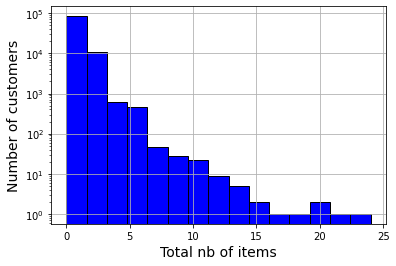

In [336]:
fig, ax = plt.subplots(1)
ax.hist(df_cust['tot_nb_items'],
        color='blue', ec='k', bins=15)
ax.set_yscale('log');
ax.set_xlabel('Total nb of items', fontsize=14);
ax.set_ylabel('Number of customers', fontsize=14);
plt.grid()

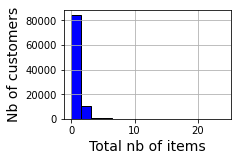

In [340]:
fig, ax = plt.subplots(1)
fig.set_size_inches(3,2)
ax.hist(df_cust['tot_nb_items'],
        color='blue', ec='k', bins=15)
# ax.set_yscale('log');
ax.set_xlabel('Total nb of items', fontsize=14);
ax.set_ylabel('Nb of customers', fontsize=14);
plt.grid()

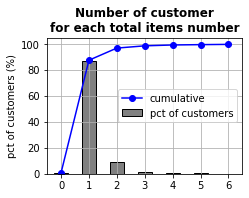

In [578]:
ser_nb_items_count=100*df_cust['tot_nb_items'].value_counts()/df_cust.shape[0]
ser_nb_items_count = ser_nb_items_count.sort_index()
ser_nb_items_count.index = [int(x) for x in ser_nb_items_count.index]

ser_nb_items_count.iloc[:7].plot.bar(color='grey', ec='k', label=('pct of customers'))
ser_nb_items_count.cumsum().iloc[:7].plot.line(c='blue', marker='o', label=('cumulative'))

plt.ylabel('pct of customers (%)')
plt.title('Number of customer\nfor each total items number', fontweight='bold')
plt.grid()
plt.legend()
plt.gcf().set_size_inches(3.5,2.5)
plt.show()

The total number of items per customers 

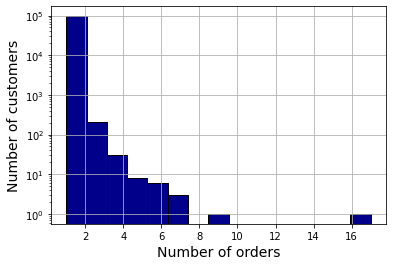

In [335]:
fig, ax = plt.subplots(1)
ax.hist(df_cust['tot_nb_ord'],
        color='darkblue', ec='k', bins=15)
ax.set_yscale('log');
ax.set_xlabel('Number of orders', fontsize=14);
ax.set_ylabel('Number of customers', fontsize=14);
plt.grid()

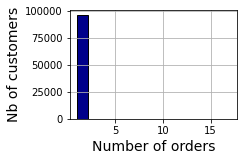

In [527]:
fig, ax = plt.subplots(1)
fig.set_size_inches(3,2)
ax.hist(df_cust['tot_nb_ord'],
        color='darkblue', ec='k', bins=15)
ax.set_xlabel('Number of orders', fontsize=14);
ax.set_ylabel('Nb of customers', fontsize=14);
plt.grid()

In [530]:
ser_nb_orders_count

1    96.88
2     2.86
3     0.21
4     0.03
5     0.01
6     0.01
7     0.00
9     0.00
17    0.00
Name: tot_nb_ord, dtype: float64

In [531]:
ser_nb_orders_count.cumsum()

1     96.88
2     99.74
3     99.95
4     99.98
5     99.99
6     99.99
7    100.00
9    100.00
17   100.00
Name: tot_nb_ord, dtype: float64

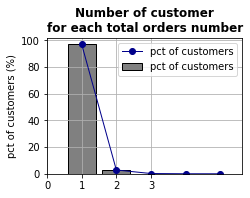

In [574]:
ser_nb_orders_count=100*df_cust['tot_nb_ord'].value_counts()/df_cust.shape[0]
ser_nb_orders_count = ser_nb_orders_count.sort_index()
ser_nb_orders_count.index = [int(x) for x in ser_nb_orders_count.index]

# ser_nb_orders_count.plot.bar(color='grey', ec='k', label=('pct of customers'))
# ser_nb_orders_count.cumsum().plot.line(c='darkblue', marker='o', label=('cumulative'))
plt.bar(x=ser_nb_orders_count.iloc[:5].index,
        height=ser_nb_orders_count.iloc[:5].values,
        color='grey', ec='k', label=('pct of customers'))
plt.plot(ser_nb_orders_count.iloc[:5].index,
         ser_nb_orders_count.iloc[:5].values,
         color='darkblue', marker='o',
         lw=1, label=('pct of customers'))

plt.ylabel('pct of customers (%)')
plt.title('Number of customer\nfor each total orders number', fontweight='bold')
plt.grid()
plt.xticks(range(4))
plt.legend()
plt.gcf().set_size_inches(3.5,2.5)
plt.show()

#### Paytype correlations

Is the type of payment correlated to other quantitative features ?

In [396]:
df_cust['cum_paytype'] = df_cust['cum_paytype'].replace('0','N')

In [405]:
df_cum_paytypes = pd.DataFrame({'customers pct': 100*df_cust['cum_paytype'].value_counts()/\
                               df_cust.shape[0]})
df_cum_paytypes['paytype'] = ['Credit card', 'Boleto', 'Credit card + Voucher',
                              'Voucher', 'Debit card', 'Not defined',
                              'Credit card' + 'Debit card' ]
df_cum_paytypes = df_cum_paytypes[['paytype', 'customers pct']]
df_cum_paytypes

,paytype,customers pct
C,Credit card,74.69
B,Boleto,19.90
CV,Credit card + Voucher,2.25
V,Voucher,1.60
D,Debit card,1.55
N,Not defined,0.00
CD,Credit cardDebit card,0.00


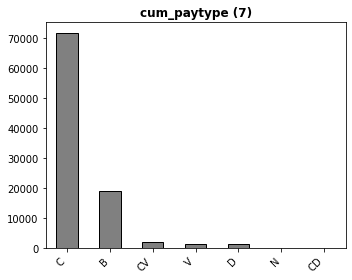

In [410]:
plot_barplots(df=df_cust, cols=['cum_paytype'], figsize=(5,4), layout=(1,1))

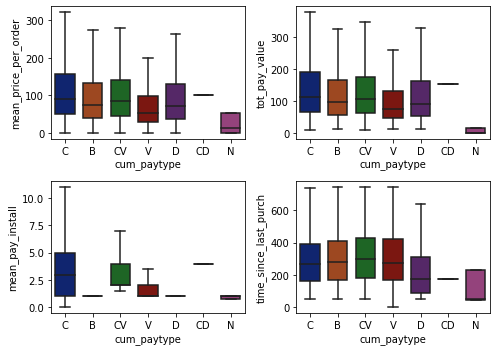

In [411]:
fig = plt.figure(figsize=(7,5))
layout=(2,2)
with sns.color_palette('dark'):
    for i, col in enumerate(['mean_price_per_order', 'tot_pay_value',
                             'mean_pay_install', 'time_since_last_purch'],1):
        ax = fig.add_subplot(*layout,i)
        sns.boxplot(data=df_cust,
                    x='cum_paytype', y=col, width=0.7, showfliers=False, ax=ax)
plt.tight_layout()
plt.show()

#### Product categories

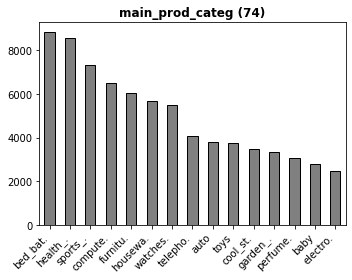

In [412]:
plot_barplots(df=df_cust, cols=['main_prod_categ'],  figsize=(5,4), layout=(1,1))

In [418]:
df_categ = pd.DataFrame({'product cat. (%)': \
                                100*df_cust['main_prod_categ'].value_counts()/\
                                df_cust.shape[0]})

In [420]:
df_categ['cumul. (%)'] = df_categ['product cat. (%)'].cumsum()

In [437]:
df_categ.head(10)

,product cat. (%),cumul. (%)
bed_bath_table,9.18,9.18
health_beauty,8.90,18.08
sports_leisure,7.64,25.72
computers_accessories,6.74,32.45
furniture_decor,6.26,38.71
housewares,5.89,44.61
watches_gifts,5.69,50.30
telephony,4.23,54.53
auto,3.95,58.48
toys,3.91,62.39


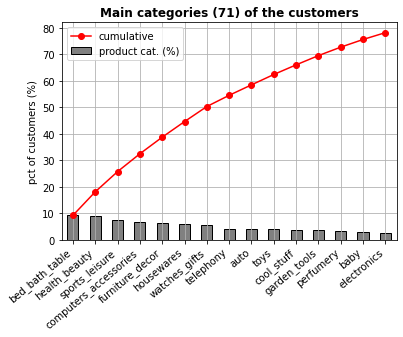

In [466]:
df_categ.iloc[:15,0].plot.bar(color='grey', ec='k')
df_categ.iloc[:15,1].plot.line(c='red', marker='o', label=('cumulative'))
plt.xticks(rotation=40, ha='right')
plt.ylabel('pct of customers (%)')
plt.title('Main categories (71) of the customers', fontweight='bold')
plt.grid()
plt.legend()
plt.show()

What is the value of the categories (on the 12 big categories) ?


In [468]:
cat_cols = df_cust.columns[df_cust.columns.str.contains('cat_')]
cat_value = df_cust[cat_cols].sum().sort_values(ascending=False).to_frame()\
    .rename(columns={0:'Cumulative value'})
cat_value

,Cumulative value
cat_electronics_tot_nb,3479997.59
cat_leisure_tot_nb,3068838.38
cat_home_tot_nb,3062531.90
cat_furniture_tot_nb,2187882.07
cat_hygiene_tot_nb,2071138.69
cat_miscellaneous_tot_nb,1400990.15
cat_diy_tot_nb,838080.54
cat_office_tot_nb,544573.54
cat_fashion_tot_nb,202218.68
cat_unknown_tot_nb,179535.28


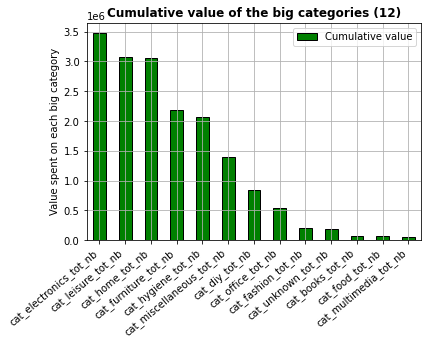

In [474]:
cat_value.plot.bar(color='green', ec='k')
plt.xticks(rotation=40, ha='right')
plt.ylabel('Value spent on each big category')
plt.title('Cumulative value of the big categories (12)', fontweight='bold')
plt.grid()
plt.show()

In [ ]:
speak("data exploration: done")

## 3 Exportation of the Customers dataset

Now we export the dataset of aggregated orders in a .csv file.

In [ ]:
df_cust.head()

,cust_region,mean_nb_items_per_ord,tot_nb_items,mean_freight_val_per_order,tot_freight_val,mean_price_per_order,tot_price,tot_nb_deliv_ord,avg_freight_payval_ratio,tot_nb_ord,mean_ship_delay,mean_ship_time,single_purch,nb_not_rec_orders,time_since_last_purch,time_since_first_purch,mean_prod_vol_cm3,tot_comment_length,mean_prod_descr_length,mean_prod_wei_g,mean_comment_length,mean_rev_score,mean_pay_value_per_order,tot_pay_value,paytype_not_defined_tot_nb,paytype_boleto_tot_nb,mean_pay_install,paytype_voucher_tot_nb,paytype_debit_card_tot_nb,paytype_credit_card_tot_nb,cat_multimedia_tot_nb,cat_office_tot_nb,cat_leisure_tot_nb,cat_home_tot_nb,cat_food_tot_nb,cat_unknown_tot_nb,cat_diy_tot_nb,cat_electronics_tot_nb,cat_furniture_tot_nb,cat_hygiene_tot_nb,cat_fashion_tot_nb,cat_miscellaneous_tot_nb,cat_books_tot_nb
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,SE,1.00,1.00,12.00,12.00,129.90,129.90,1,0.08,1,6,6,1,0,160,160,7616.00,111.00,236.00,1500.00,111.00,5.00,141.90,141.90,0.00,0.00,8.00,0.00,0.00,1.00,0.00,0.00,0.00,129.90,0.00,0.00,0.00,0.00,129.90,0.00,0.00,0.00,0.00
0000b849f77a49e4a4ce2b2a4ca5be3f,SE,1.00,1.00,8.29,8.29,18.90,18.90,1,0.29,1,3,3,1,0,163,163,5148.00,0.00,635.00,375.00,0.00,4.00,27.19,27.19,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18.90,0.00,0.00,0.00
0000f46a3911fa3c0805444483337064,S,1.00,1.00,17.22,17.22,69.00,69.00,1,0.20,1,25,25,1,0,585,585,43750.00,0.00,177.00,1500.00,0.00,3.00,86.22,86.22,0.00,0.00,8.00,0.00,0.00,1.00,0.00,69.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0000f6ccb0745a6a4b88665a16c9f078,N,1.00,1.00,17.63,17.63,25.99,25.99,1,0.40,1,20,20,1,0,369,369,1045.00,12.00,1741.00,150.00,12.00,4.00,43.62,43.62,0.00,0.00,4.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,25.99,0.00,0.00,0.00,0.00,0.00
0004aac84e0df4da2b147fca70cf8255,SE,1.00,1.00,16.89,16.89,180.00,180.00,1,0.09,1,13,13,1,0,336,336,528.00,0.00,794.00,6050.00,0.00,5.00,196.89,196.89,0.00,0.00,6.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,180.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
df_cust.reset_index().to_csv('agg_customers.csv')

In [ ]:
speak('exportation of cleaned data: done')